### Load library and Rdata

In [8]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(devtools))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(org.Mm.eg.db))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(EnhancedVolcano))
suppressPackageStartupMessages(library(tools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(khroma))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(gridtext))
suppressPackageStartupMessages(library(ggraph))
suppressPackageStartupMessages(library(igraph))

In [9]:
load("SeuratData_DEGs.RData")

### Figure A. DEG overlaps
Venn Diagrams were created using numbers from the Upset Figure below

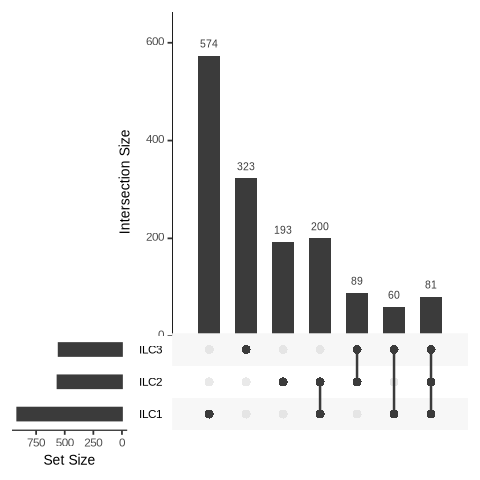

In [15]:
plot_list <- list(deg1$gene_symbol, deg2$gene_symbol, deg3$gene_symbol)     
names(plot_list) <- c('ILC1', 'ILC2', 'ILC3')
options(repr.plot.width = 4, repr.plot.height = 4)
UpSetR::upset(fromList(plot_list))

### Figure B. Pathway Overlaps
Venn Diagrams were created using numbers from the Upset Figure below

In [ ]:
enriched <- read.csv('String_ILCs_deg1_deg2_deg3.csv') %>% filter(category %in% c('GO Process', 'KEGG', 'Reactome','WikiPathways'))
colnames(enriched) <- c('ilc', 'category', 'term.ID', 'term.description', 'gene_count', 'background', 'strength', 'FDR', 'gene_ID', 'genes')
path1 <- enriched %>% filter(ilc == 'ilc1') 
path2 <- enriched %>% filter(ilc == 'ilc2') 
path3 <- enriched %>% filter(ilc == 'ilc3') 
plot_list <- list(path1$term.ID, path2$term.ID, path3$term.ID) 
names(plot_list) <- c('ILC1', 'ILC2', 'ILC3')
options(repr.plot.width = 4, repr.plot.height = 4)
UpSetR::upset(fromList(plot_list))

### Figure C. Heatmap of Shared pathways enriched by ILCs
#### Prepare the plot data

In [10]:
# Join DEG results with Seurat objects
gather_dat_for_genes <- function(seurat_dat, genes, deg, deg1, deg2, deg3){

    DefaultAssay(seurat_dat) <- "RNA"
    Idents(seurat_dat) <- seurat_dat@meta.data$sample
    p <- DotPlot(object = seurat_dat, features = unique(genes))
    df <- p$data
    cytdat <- df %>% dplyr::select(-pct.exp, -avg.exp) %>% tidyr::pivot_wider(names_from = id, values_from = avg.exp.scaled) %>% as.data.frame() 
    row.names(cytdat) <- cytdat$features.plot 
    cytdat <- cytdat %>%
        dplyr::rename(gene_symbol = features.plot) %>%
        left_join(deg, by = 'gene_symbol') %>%
            dplyr::select(-c(p_val, treatment, control)) %>%
            dplyr::rename(d0 = direction) %>%
            dplyr::rename(p0 = p_val_adj) %>%
            dplyr::rename(fc0 = avg_log2FC) %>%
        left_join(deg1, by = 'gene_symbol') %>%
            dplyr::select(-c(p_val, treatment, control)) %>%
            dplyr::rename(d1 = direction) %>%
            dplyr::rename(p1 = p_val_adj) %>%
            dplyr::rename(fc1 = avg_log2FC) %>%
        left_join(deg2, by = 'gene_symbol') %>%
            dplyr::select(-c(p_val, treatment, control)) %>%
            dplyr::rename(d2 = direction) %>%
            dplyr::rename(p2 = p_val_adj) %>%
            dplyr::rename(fc2 = avg_log2FC) %>%
        left_join(deg3, by = 'gene_symbol') %>%
            dplyr::select(-c(p_val, treatment, control)) %>%
            dplyr::rename(d3 = direction) %>%
            dplyr::rename(p3 = p_val_adj) %>%
            dplyr::rename(fc3 = avg_log2FC) %>%
        mutate(
            induce1  = ifelse(!is.na(d1) & mILC1_control <= 0 & mILC1_treatment > 0 & d1 == 'up', 1, 0),
            induce2  = ifelse(!is.na(d2) & mILC2_control <= 0 & mILC2_treatment > 0 & d2 == 'up', 1, 0),
            induce3  = ifelse(!is.na(d3) & mILC3_control <= 0 & mILC3_treatment > 0 & d3 == 'up', 1, 0),
            label = ifelse((induce1 == 1 & induce2 == 1 & induce3 == 1), "trained", "heterotypic"))%>%
        relocate(mILC1_treatment, .after = mILC1_control) %>%
        relocate(mILC2_treatment, .after = mILC2_control) %>%
        mutate(deg_count = (4 - rowSums(is.na(dplyr::select(., d0, d1, d2, d3))))) %>%
        dplyr::select(gene_symbol, deg_count, label, induce1, induce2, induce3, mILC1_control, mILC1_treatment, mILC2_control, mILC2_treatment, mILC3_control, mILC3_treatment) %>%
        mutate(
            Induce = case_when(
                induce1 == 1 & induce2 != 1 & induce3 != 1 ~ 'ILC1',
                induce1 != 1 & induce2 == 1 & induce3 != 1 ~ 'ILC2',
                induce1 != 1 & induce2 != 1 & induce3 == 1 ~ 'ILC3',
                induce1 == 1 & induce2 == 1 & induce3 != 1 ~ 'ILC1, ILC2',
                induce1 == 1 & induce2 != 1 & induce3 == 1 ~ 'ILC1, ILC3',
                induce1 != 1 & induce2 == 1 & induce3 == 1 ~ 'ILC2, ILC3',
                induce1 == 1 & induce2 == 1 & induce3 == 1 ~ 'ILC1, ILC2, ILC3')) %>%
        mutate(Induce = ifelse(is.na(Induce), "Insignificant", Induce)) %>%
        mutate(Trained = ifelse(Induce == 'Insignificant', "Baseline", "Trained"))
    return(cytdat)
    }

In [11]:
# Get expression data for genes
get_exp_dat <- function(seurat_object, genes_to_plot){
  DefaultAssay(seurat_object) <- "RNA"
  Idents(seurat_object) <- seurat_object@meta.data$sample
  p <- DotPlot(object = seurat_object, features = genes_to_plot)
  df <- p$data
  exp_mat <- df %>% dplyr::select(-pct.exp, -avg.exp) %>% tidyr::pivot_wider(names_from = id, values_from = avg.exp.scaled) %>% as.data.frame() 
  row.names(exp_mat) <- exp_mat$features.plot  
  return(exp_mat)
}

In [12]:
## get genes from pathways
gdat_path <- read.csv('String_Shared_Terms_GO_WIKI_KEGG_REACTOME.csv') %>% 
    filter(subgroup == 0) %>% 
    dplyr::select(term.ID, term.description, category, group, observed.gene.count, fdr, genes) %>%
    tidyr::separate_rows(genes, sep = ",") %>%
    dplyr::select(genes, term.description) %>%
    distinct() %>%
    mutate(presence = 1) %>%  # Create a column to indicate presence
    tidyr::pivot_wider(names_from = term.description, values_from = presence, values_fill = list(presence = 0)) %>%
    mutate(row_sum = rowSums(across(-genes))) %>%  # Calculate row sums, excluding the 'genes' column
    arrange(desc(row_sum)) %>%  # Sort rows by rowSums in descending order
    dplyr::select(-row_sum)

## get induced genes
induced <- gather_dat_for_genes(dat, gdat_path$genes, deg, deg1, deg2, deg3) %>% filter(deg_count > 0) %>% 
    filter(mILC1_control < 0 & mILC2_control < 0 & mILC3_control < 0 & mILC1_treatment > 0 & mILC2_treatment > 0 & mILC3_treatment > 0) %>% pull(gene_symbol) 

## filter out genes that were only present in one pathway
gdat_path <- gdat_path %>% filter(genes %in% induced) %>% arrange(genes) %>% 
  rowwise() %>%
  filter(sum(c_across(-all_of('genes'))) > 1) %>%
  ungroup() %>% dplyr::select(genes, where(~ is.numeric(.) && sum(.) > 0))

## get pathways with multi-function genes
enrich_df <- read.csv('String_Shared_Terms_GO_WIKI_KEGG_REACTOME.csv') %>% 
    filter(subgroup == 0) %>% 
    dplyr::select(term.ID, term.description, category, group, observed.gene.count, fdr) %>% 
    filter(term.description %in% colnames(gdat_path)[-1])

#### Heatmap Function

In [13]:
make_heatmap_with_pathways <- function(seurat_object, gdat, genes_to_plot, enrich_df, row_split, font_size, hp_height, dot_height, heatmap_width){

    # heatmap 1: gene expression 
    p <- DotPlot(seurat_object, features = genes_to_plot, assay = "RNA", group.by = "sample")
    df <- p$data
    exp_mat <- df %>% dplyr::select(-pct.exp, -avg.exp) %>% tidyr::pivot_wider(names_from = id, values_from = avg.exp.scaled) %>% as.data.frame() 
    row.names(exp_mat) <- exp_mat$features.plot  
    exp_mat <- exp_mat[,-1] %>% as.matrix()
    exp_mat <- exp_mat %>% as.data.frame %>% 
        dplyr::select(mILC1_control, mILC2_control, mILC3_control, mILC1_treatment, mILC2_treatment, mILC3_treatment) %>% t
        rownames(exp_mat) <- c('ILC1', 'ILC2', 'ILC3', ' ILC1', ' ILC2', ' ILC3')

    # Condition label
    #conditions <- c('Naive', 'Trained')
    condition_split <- c('Naive', 'Naive', 'Naive', 'Trained', 'Trained', 'Trained')

    hp <- Heatmap(exp_mat,
        heatmap_legend_param=list(title = "Scaled\nExpression"),
        col = circlize::colorRamp2(c(-1.5,  0,  1.5), c('#003399','#f0ffff', '#b31b1b')),
        row_split = condition_split,
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        show_column_dend = FALSE,
        row_names_gp = gpar(fontsize = font_size, fontface = "bold"),
        column_names_rot = 45, 
        column_names_gp = gpar(fontsize = font_size, fontface = "bold"),
        row_names_side = "left",
        column_names_side = "top",
        column_title = NULL,
        #row_title_rot = 0,
        #row_title_gp = gpar(fontsize = font_size, fontface = "bold"),
        heatmap_height = unit(hp_height, "cm")) 

    # heatmap 2: pathway presence
    gbinary <- gdat %>% as.data.frame
    rownames(gbinary) <- gdat$genes 
    gbinary <- gbinary %>% dplyr::select(-genes) %>%  mutate_all(~ ifelse(. > 0, "Yes", "No")) %>% as.matrix %>% t

    # bar plot 
    bardat <- data.frame(term.description = gbinary %>% rownames) %>% left_join(enrich_df, by = 'term.description')

    factor_col_fun <- c("No" = "#d3d3d3", "Yes" = "black")

    # Row annotation: total genes barplot
    gene_count_label = str_wrap('Total', width = 5)
    total_genes_barplot <- rowAnnotation(
            Total = anno_numeric(
                bardat$observed.gene.count, 
                bg_gp = gpar(fill = "#c4aead", col = "#c4aead"), 
                labels_gp = gpar(col = "black", fontsize = font_size-1, fontface = "bold"),
                align_to = "right", 
                width = unit(2, "cm")), 
            annotation_name_rot = 45, 
            annotation_label = gt_render(gene_count_label,  gp = gpar(fontsize = font_size, fontface = "bold")),
            annotation_name_side = 'top')

    # Row annotation: Group label
    wrapped_labels <- str_wrap(unique(row_split), width = 5)
    group_label <- rowAnnotation(Group = anno_block(
        align_to = split(1:length(row_split), row_split),  # Align the annotation to the row_split
        panel_fun = function(index, levels) {
        # Draw the block rectangle
        grid.rect(gp = gpar(fill = '#f4f0ec', col = "#f4f0ec"))
        
        # Use wrapped_labels based on unique(row_split) and render the text
        grid.text(wrapped_labels[which(unique(row_split) == levels[1])], 0.5, 0.5, rot = 0, gp = gpar(col = "black", fontface = "bold"))
        },
        width = unit(3, "cm")  # Set the width of the annotation block
    ))

    # Row annotation: FDR
    FDR = bardat$fdr
    FDR_col_fun = circlize::colorRamp2(c(0, 2, 3), c("red", "white", "#555555")) 
    fdr = rowAnnotation(
        FDR = anno_simple(-log10(FDR), col = FDR_col_fun),
        annotation_name_rot = 45, 
        annotation_label = gt_render('FDR', gp = gpar(fontsize = font_size, fontface = "bold")),
        annotation_name_side = 'top',
        gap = unit(2, "cm"))

    lgd_pvalue = Legend(title = "FDR", col_fun = FDR_col_fun, at = c(2, 3), labels = c("0.01", "0.001"))

    heat_dot <- Heatmap(
        gbinary, name = "Gene\nPresence", 
        col = factor_col_fun, rect_gp = gpar(type = "none"),
        cell_fun = function(j, i, x, y, width, height, fill) {
                # Draw empty rectangles for grid structure with grey borders
                grid.rect(x = x, y = y, width = width, height = height, gp = gpar(col = "#fbfbfb", fill = "#d3d3d3"))
                # Use uniformly sized circles to represent binary values (now factors)
                grid.circle(x = x, y = y, r = unit(1, "mm"),  # Fixed radius for all circles
                    gp = gpar(fill = factor_col_fun[as.character(gbinary[i, j])], col = NA))
            }, 
        column_names_side = "top", 
        row_names_side = 'right',
        column_names_gp = gpar(fontsize = font_size),
        row_names_gp = gpar(fontsize = font_size + 1, fontface = "bold"),
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        column_names_rot = 45,
        row_title  = NULL, 
        column_title = NULL,
        row_split = row_split,
        row_gap = unit(1.5, "mm"),
        heatmap_height = unit(dot_height, "cm"),
        heatmap_width = unit(heatmap_width, "cm"),
        left_annotation = c(group_label, total_genes_barplot, fdr)
        )

    heatmaps <- heat_dot %v% hp
    return(draw(heatmaps, annotation_legend_list = list(lgd_pvalue), merge_legend = TRUE, show_heatmap_legend = FALSE))
}

#### Plot the heatmap
Note: Row order may change within functional categories.

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'IFN-γ Response' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'IFN-γ Response' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'IFN-β Response' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'IFN-β Response' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'IFN-γ Response' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'IFN-γ Response' in 'mbcsToSbcs': dot substituted for <b3>”
Warn

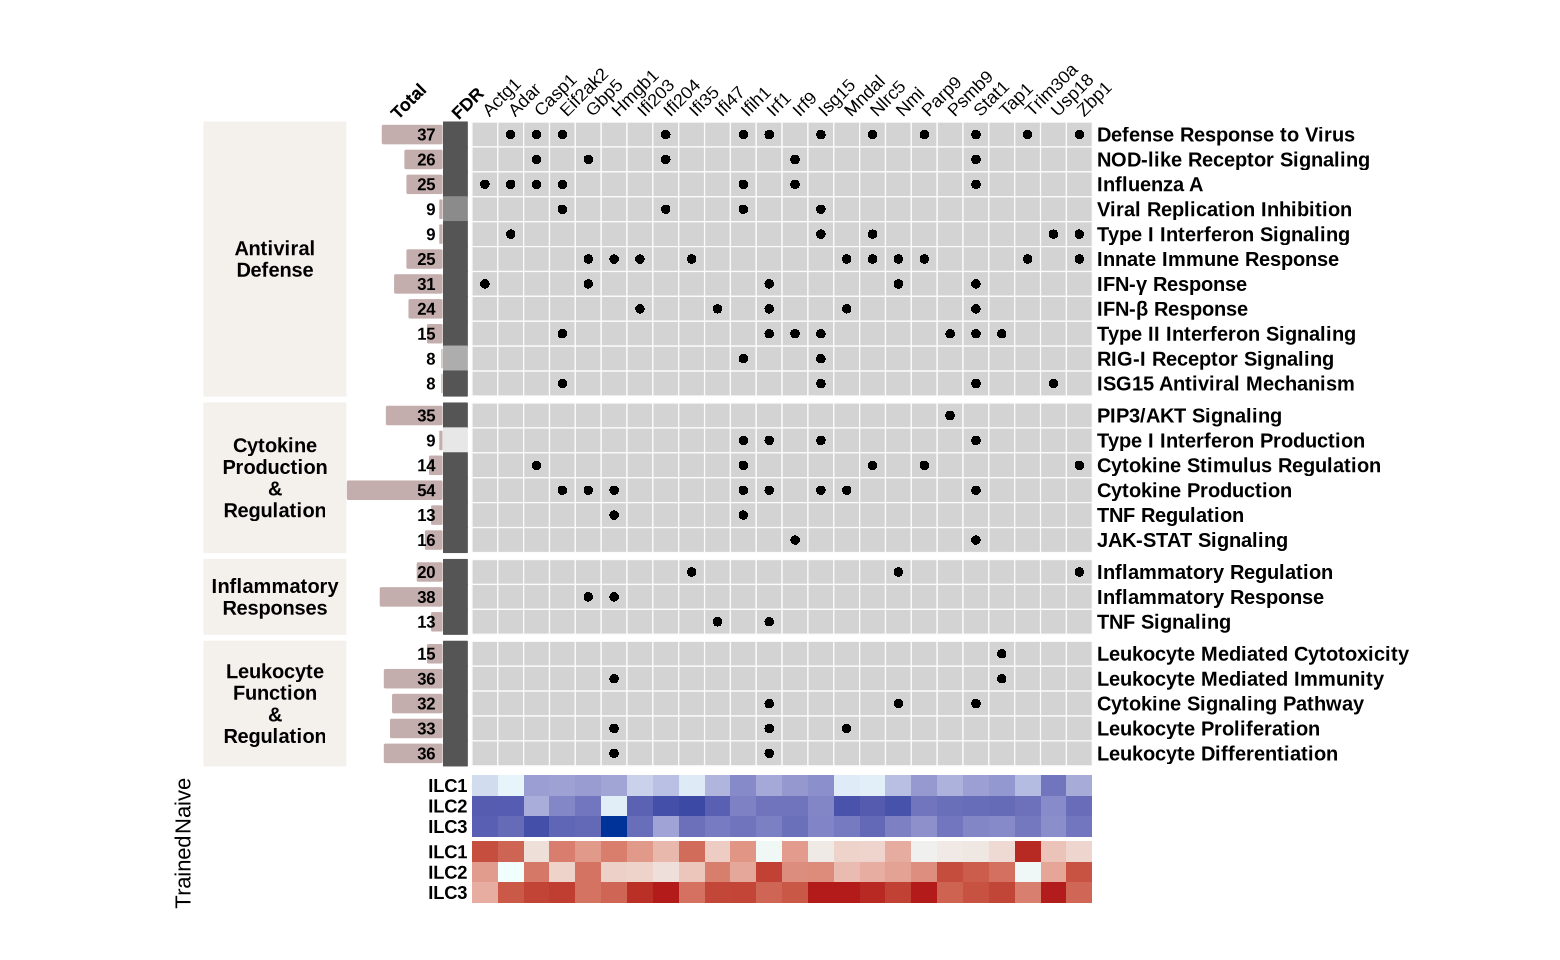

In [16]:
options(repr.plot.width = 13, repr.plot.height = 8)
#png("Figure_Heatmap_Shared_Results.png", width = 13, height = 10, units = "in", res = 800)
make_heatmap_with_pathways(
    seurat_object = dat, 
    gdat = gdat_path,
    genes_to_plot = gdat_path$genes, 
    enrich_df = enrich_df,
    row_split = enrich_df$group, 
    font_size = 11, 
    hp_height = 2.7, 
    dot_height = 15, 
    heatmap_width = 25)